# Article: [Predicting TCR-Epitope Binding Specificity Using Deep Metric Learning and Multimodal Learning](https://www.mdpi.com/2073-4425/12/4/572)

## **Objects**

#### *1. Develop a Computational Model: The paper aims to create a convolutional neural network model that utilizes deep metric learning and multimodal learning techniques to predict interactions between T cell receptors (TCRs) and Major Histocompatibility Complex class I-peptide complexes (pMHC).*

#### *2. Simultaneous TCR-Epitope Binding Prediction: The paper seeks to perform two critical tasks in TCR-epitope binding prediction: identifying the TCRs that bind a given epitope from a TCR repertoire and identifying the binding epitope of a given TCR from a list of candidate epitopes. The goal is to achieve accurate predictions for both tasks simultaneously.*

##### *3. Gain Insights into Binding Specificity: The paper aims to provide insights into the factors that determine TCR-epitope binding specificity, including the identification of key amino acid sequence patterns and positions within the TCR that are important for binding specificity. Additionally, the paper challenges the assumption that physical proximity to epitopes is the sole determinant of TCR-epitope specificity.*

## Packages

In [202]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
import torch
import matplotlib.pyplot as plt

## One-hot enocoding.

In [2]:
positives = pd.read_csv("./positive.csv")
negatives = pd.read_csv("./negative.csv")

amino_acids = []

def add_to_amino_acids(a_sequence: str):
    for acid in a_sequence:
        if acid not in amino_acids:
            amino_acids.append(acid)

positives.stack().reset_index(drop=True).apply(add_to_amino_acids)

amino_acids.sort()

amino_acid_label_encoder = LabelEncoder()
amino_acid_label_encoder.fit(amino_acids)

all_amino_acids = amino_acid_label_encoder.transform(amino_acids)

def feature_map(p_sequence):
    return [tf.one_hot(amino_acid_label_encoder.transform(list(x)), len(all_amino_acids)) for x in p_sequence]

data_cd3r = feature_map(positives["cdr3"])
data_epitope = feature_map(positives["antigen.epitope"])

2023-11-04 11:46:05.124189: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-11-04 11:46:05.124473: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-11-04 11:46:05.124487: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (matts-computer): /proc/driver/nvidia/version does not exist
2023-11-04 11:46:05.126619: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data Representation

<center>
    <img src="gene.jpg" alt="Figure 1">
</center>

### 2.2. CDR3B and Epitope Sequence Representation:



**Data Representation Goals:**

  1. Convert amino acid sequences from string format to a numeric representation.
  2. Develop a numerical procedure utilizing Atchley representation to capture physical and biochemical properties.
  3. Create matrices with specified dimensions through padding to accommodate varying sequence lengths.

### Sentence Construction with the Atchley Representation in both CDR3B and the Epitope
Fixed: Instead of constructing the sentences manually, I constructed the sentences utilizing the BertTokenizer in relateion to the amino_aciv_vocab.txt.

### Procedure encoding CDR3B and Eptiope Amino Acid Sequences as Numerical Matrices

In [151]:
def convert_to_space_separated_string(series):
    return ' '.join(series)

tokenizer = BertTokenizer(vocab_file="./amino_acid_vocab.txt")

def construct_sentences(dataframe):
    cdr3_sentences = dataframe["cdr3"]
    epitope_sentences = dataframe["antigen.epitope"]
    return cdr3_sentences, epitope_sentences

def pad_sentences(sentences, max_length):
    input_ids = []
    attention_masks = []

    for sentence in sentences:
        encoded_dict = tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt',
            return_attention_mask=True
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    return torch.stack(input_ids), torch.stack(attention_masks)

def shuffle_data(data, random_state=42):
    np.random.seed(random_state)
    np.random.shuffle(data)
    return data

def train_test_split_no_shuffle(data, test_size):
    split_index = int(len(data) * (1 - test_size))
    return data[:split_index], data[split_index:]
    


max_length = 32


positives = pd.read_csv("./positive.csv")

cdr3_sequence_epitope_encoder = LabelEncoder()
cdr3_sequence_epitope_encoder.fit(positives["antigen.epitope"])

cdr3_labels = cdr3_sequence_epitope_encoder.transform(positives["antigen.epitope"])
for column in positives.columns:
    positives[column] = positives[column].apply(convert_to_space_separated_string)

cdr3_sentences, epitope_sentences = construct_sentences(positives)

shuffle_data(cdr3_sentences, 42)
shuffle_data(epitope_sentences, 42)
shuffle_data(cdr3_labels, 42)

cdr3_input_ids, cdr3_attention_masks = pad_sentences(cdr3_sentences, max_length)
epitope_input_ids, epitope_attention_masks = pad_sentences(epitope_sentences, max_length)

cdr3_combined = torch.cat((cdr3_input_ids, cdr3_attention_masks), dim=1)
epitope_combined = torch.cat((epitope_input_ids, epitope_attention_masks), dim=1)


cdr3_train_data, cdr3_test_data = train_test_split_no_shuffle(cdr3_combined, test_size=0.2)
cdr3_labels_train_data, cdr3_labels_test_data = train_test_split_no_shuffle(cdr3_labels, test_size=0.2)
epitope_train_data, epitope_test_data = train_test_split_no_shuffle(epitope_combined, test_size=0.2)



cdr3_train_data = cdr3_train_data.transpose(0,1)
cdr3_test_data = cdr3_test_data.transpose(0,1)
epitope_train_data = epitope_train_data.transpose(0,1)
epitope_test_data = epitope_test_data.transpose(0,1)
cdr3_combined.shape

/tmp/ipykernel_1436039/3608070648.py:32: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(data)


torch.Size([12735, 2, 32])

### Initialization of Training 

In [216]:
from transformers import *

config = BertConfig.from_json_file("./bert_config.json")

model = BertForMaskedLM(config=config) # change this line and flag what we're using

device = "cuda" if torch.cuda.is_available() else "cpu"

cdr3_train_data = cdr3_train_data.to(device)
cdr3_test_data = cdr3_test_data.to(device)
epitope_train_data = epitope_train_data.to(device)
epitope_test_data = epitope_test_data.to(device)

model.to(device)

# print("Model's state_dict:")
# for param_tensor in model.state_dict():
#     print(param_tensor, "\t", model.state_dict()[param_tensor].size())

print("\nModel's parameters:")
num_params = sum(p.numel() for p in model.parameters())
print(f'Total Parameters: {num_params}')

print("\nModel's parameters (only those that require gradients):")
num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total Trainable Parameters: {num_trainable_params}')

print("\nModel's architecture:")
print(model)


Model's parameters:
Total Parameters: 60697

Model's parameters (only those that require gradients):
Total Trainable Parameters: 60697

Model's architecture:
BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(25, 64, padding_idx=0)
      (position_embeddings): Embedding(64, 64)
      (token_type_embeddings): Embedding(2, 64)
      (LayerNorm): LayerNorm((64,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-1): 2 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=64, out_features=64, bias=True)
              (key): Linear(in_features=64, out_features=64, bias=True)
              (value): Linear(in_features=64, out_features=64, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
  

### Triplet Loss Function:
Article: [PyTorch Metric Learning](https://kevinmusgrave.github.io/pytorch-metric-learning/#:~:text=This%20customized%20triplet%20loss%20has,than%200.3%20will%20be%20discarded.)

In [7]:
!pip install pytorch_metric_learning 
from pytorch_metric_learning.distances import CosineSimilarity
from pytorch_metric_learning.reducers import ThresholdReducer
from pytorch_metric_learning.regularizers import LpRegularizer
from pytorch_metric_learning import losses

In [11]:
# Testing the loss function...
loss_func = torch.nn.TripletMarginLoss(margin=1.0, p=2.0, eps=1e-06, swap=False, reduction='mean')
anchor = torch.randn(100, 128, requires_grad=True)
positive = torch.randn(100, 128, requires_grad=True)
negative = torch.randn(100, 128, requires_grad=True)
output = loss_func(anchor, positive, negative)

#### Analyze the embedding between the CDR3 and the Epitope.

#### 1. BertForPreTraining


In [192]:
import torch
from transformers import BertTokenizer, BertForPreTraining, BertForMaskedLM, LineByLineTextDataset, DataCollatorForLanguageModeling, Trainer, TrainingArguments

# Load the BERT tokenizer
config = BertConfig.from_json_file("./bert_config.json")

model = BertForMaskedLM(config=config) # change this line and flag what we're using

# Define your training data
# Here, we'll use dummy data for simplicity. In practice, you'd use a large text corpus.
# train_data = "Hello, my name is [MASK]. I live in [MASK]."

# Tokenize and convert the training data into input tensors
input_ids = tokenizer.encode(open("positive.csv", "r").read()[:1000], add_special_tokens=True, return_tensors="pt")
labels = input_ids.clone()

# Create a dataset and data collator
# dataset = LineByLineTextDataset(tokenizer=tokenizer, file_path="positive.csv", block_size=128)
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=True, mlm_probability=0.15)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./bert-pretraining",
    overwrite_output_dir=True,
    num_train_epochs=100,
    per_device_train_batch_size=16,
    save_steps=10_000,
)

# Create a Trainer for pretraining
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset,
)

# Start pretraining
trainer.train()
trainer.train()

# Save the pretrained model

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


NameError: name 'dataset' is not defined

Epoch: 0 | Train loss: 0.9592124223709106 | Test loss 0.9470370411872864
Epoch: 100 | Train loss: 0.8700257539749146 | Test loss 0.8490696549415588
Epoch: 200 | Train loss: 0.8875263333320618 | Test loss 0.8814665675163269
Epoch: 300 | Train loss: 0.8878641724586487 | Test loss 0.8495428562164307
Epoch: 400 | Train loss: 0.865502655506134 | Test loss 0.8798403739929199
Epoch: 500 | Train loss: 0.8430296778678894 | Test loss 0.7978895306587219
Epoch: 600 | Train loss: 0.8484196662902832 | Test loss 0.8908151984214783
Epoch: 700 | Train loss: 0.8470801711082458 | Test loss 0.8240438103675842
Epoch: 800 | Train loss: 0.8313890695571899 | Test loss 0.7991370558738708
Epoch: 900 | Train loss: 0.6272388696670532 | Test loss 0.5107057094573975
Epoch: 1000 | Train loss: 0.6866202354431152 | Test loss 0.8331097364425659
Epoch: 1100 | Train loss: 0.764319658279419 | Test loss 0.684531033039093
Epoch: 1200 | Train loss: 0.6857355833053589 | Test loss 0.7456405162811279
Epoch: 1300 | Train loss: 0

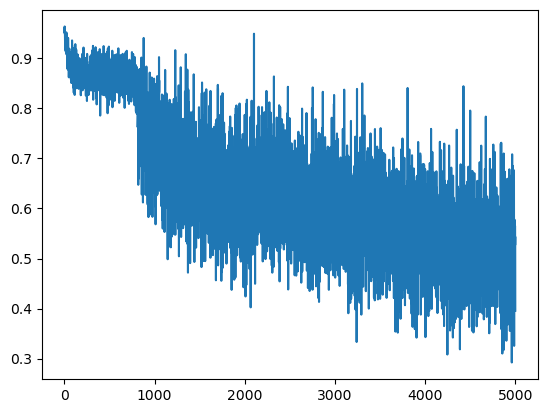

In [218]:
steps = 5000
X_train = cdr3_train_data
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
batch_size = 64
output_every_x_steps = 100

def get_anchor_positive_index_negative_index(labels):
    random_label = np.random.choice(np.unique(labels))
    random_labels_we_want = labels[labels == random_label]
    negative_index = np.random.choice(np.where(labels != random_label)[0])
    indexs = (np.where(labels == random_label))[0]
    random_index_0 = None
    try:
        random_index_0 = np.random.choice(indexs)
    except ValueError:
        print(random_index_0, random_label, indexs)

    indexs = np.delete(indexs, np.where(indexs == random_index_0))
    if len(indexs) == 0:
        return random_index_0, random_index_0, negative_index
    random_index_1 = np.random.choice(indexs)
    return random_index_0, random_index_1, negative_index

def run_model_on_input_and_get_triplet_loss(model, batch_size, cdr3_train_data, cdr3_labels_train_data, loss_func):
    anchor_indexs = []
    positive_indexs = []
    negative_indexs = []

    for i in range(batch_size):
        anchor_index, positive_index, negative_index = get_anchor_positive_index_negative_index(cdr3_labels_train_data)
        anchor_indexs.append(anchor_index), positive_indexs.append(positive_index), negative_indexs.append(negative_index)
    # print(anchor_index, positive_index)
    # print(cdr3_train_data[0][anchor_index], cdr3_train_data[1][anchor_index])
    anchor_output = model(cdr3_train_data[0][anchor_indexs],cdr3_train_data[1][anchor_indexs])
    positive_output = model(cdr3_train_data[0][positive_indexs],cdr3_train_data[1][positive_indexs])
    negative_output = model(cdr3_train_data[0][negative_indexs],cdr3_train_data[1][negative_indexs])

    # Select anchor, positive, negative

    # 2. Calculate loss
    loss = loss_func(anchor_output[0], positive_output[0], negative_output[0])
    return loss

losses = []
test_losses = []
summed_loss = 0
summed_test_loss = 0
for step in range(steps):
    ### Training
    model.train() # train mode is on by default after construction
    
    # print(loss)

    # 3. Zero grad optimizer
    optimizer.zero_grad()
    loss = run_model_on_input_and_get_triplet_loss(model, batch_size, cdr3_train_data, cdr3_labels_train_data, loss_func)
    # 4. Loss backward
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()
    summed_loss += loss.detach().numpy()

    # ### Testing
    # model.eval() # put the model in evaluation mode for testing (inference)
    # # 1. Forward pass

        # 2. Calculate the loss
    with torch.inference_mode():
        test_loss = run_model_on_input_and_get_triplet_loss(model, batch_size, cdr3_test_data, cdr3_labels_test_data, loss_func)
    summed_test_loss += test_loss.detach().numpy()
    test_losses.append(test_loss.detach().numpy())
        
    losses.append(loss.detach().numpy())
    if step % output_every_x_steps == 0:
        summed_loss = 0
        summed_test_loss = 0
        print(f"Step: {step} | Train loss: {summed_loss / output_every_x_steps} | Test loss {summed_test_loss / output_every_x_steps}")
plt.plot(losses)

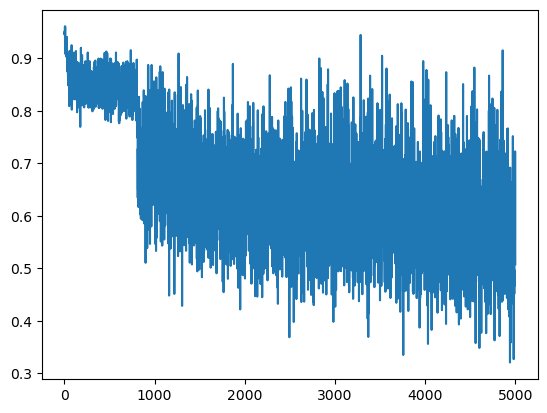

In [219]:
plt.plot(test_losses)

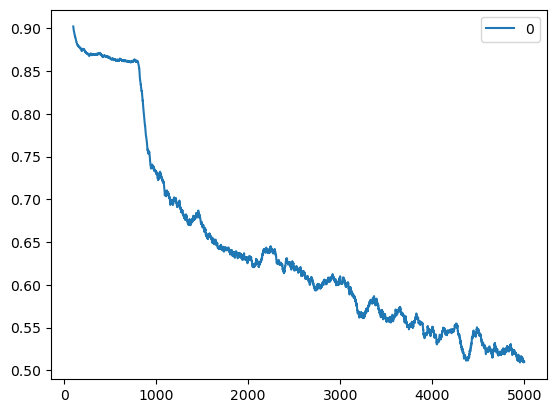

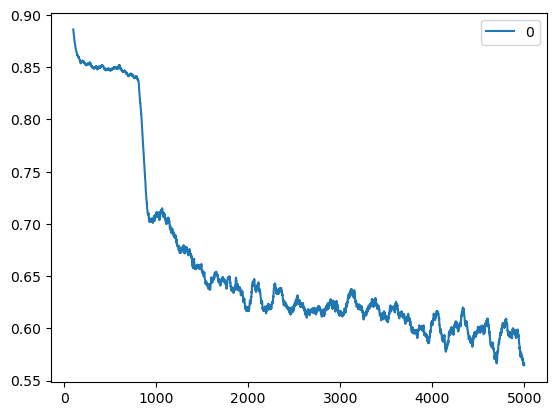

In [220]:
import pandas as pd

def plot_rolling_average_of_losses(losses, n_rolling_average = 100):
    df = pd.DataFrame(losses)
    df.rolling(n_rolling_average).mean().plot()
    plt.show()

# create rolling average 
plot_rolling_average_of_losses(losses, 100)
plot_rolling_average_of_losses(test_losses, 100)

In [150]:
cdr3_train_data.shape

torch.Size([10188, 2, 32])

torch.Size([100, 128])


ValueError: labels must be a 1D tensor of shape (batch_size,)

In [26]:
loss_func = torch.nn.TripletMarginLoss(margin=1.0, p=2.0, eps=1e-06, swap=False, reduction='mean')
anchor = torch.randn(100, 128, requires_grad=True)
positive = torch.randn(100, 128, requires_grad=True)
negative = torch.randn(100, 128, requires_grad=True)
output = loss_func(anchor, positive, negative)

tensor(1.0556, grad_fn=<MeanBackward0>)

#### 2. BertForMaskedLM


#### 3. BertForNextPrediction